In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the Data
df = pd.read_csv('FTSE Malaysia KLCI Historical Data.csv')

# 2. Fix the "Date" Column
# The raw data is likely sorted Newest -> Oldest.
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date', ascending=True).reset_index(drop=True)

# 3. Fix the "Price", "Open", "High", "Low" Columns
# Remove comma and turn them into numbers.
cols_to_fix = ['Price', 'Open', 'High', 'Low']
for col in cols_to_fix:
    # Remove comma and turn them into float
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# 4. Fix the Volume Column
# It has "M" for Millions and "K" for Thousands (e.g., "26.77M").
def clean_volume(x):
    if isinstance(x, str):
        x = x.strip()
        if x == '-': return 0
        if 'M' in x:
            return float(x.replace('M', '')) * 1_000_000
        if 'K' in x:
            return float(x.replace('K', '')) * 1_000
    return float(x)

df['Vol.'] = df['Vol.'].apply(clean_volume)

# 5. Fix "Change %"
# Remove the '%' sign and convert to float
df['Change %'] = df['Change %'].astype(str).str.replace('%', '').astype(float)

# Check if it worked
print("Data Cleaned Successfully")
print(df.info())
print(df.head())

Data Cleaned Successfully
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451 entries, 0 to 2450
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2451 non-null   datetime64[ns]
 1   Price     2451 non-null   float64       
 2   Open      2451 non-null   float64       
 3   High      2451 non-null   float64       
 4   Low       2451 non-null   float64       
 5   Vol.      2450 non-null   float64       
 6   Change %  2451 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 134.2 KB
None
        Date    Price     Open     High      Low         Vol.  Change %
0 2015-11-19  1660.06  1657.09  1664.30  1655.99  109630000.0      0.21
1 2015-11-20  1661.89  1660.17  1663.48  1657.13  104970000.0      0.11
2 2015-11-23  1670.90  1661.59  1673.92  1661.59  106120000.0      0.54
3 2015-11-24  1677.03  1678.68  1686.69  1677.03  142980000.0      0.37
4 2015-11-25  1684.42  1672.

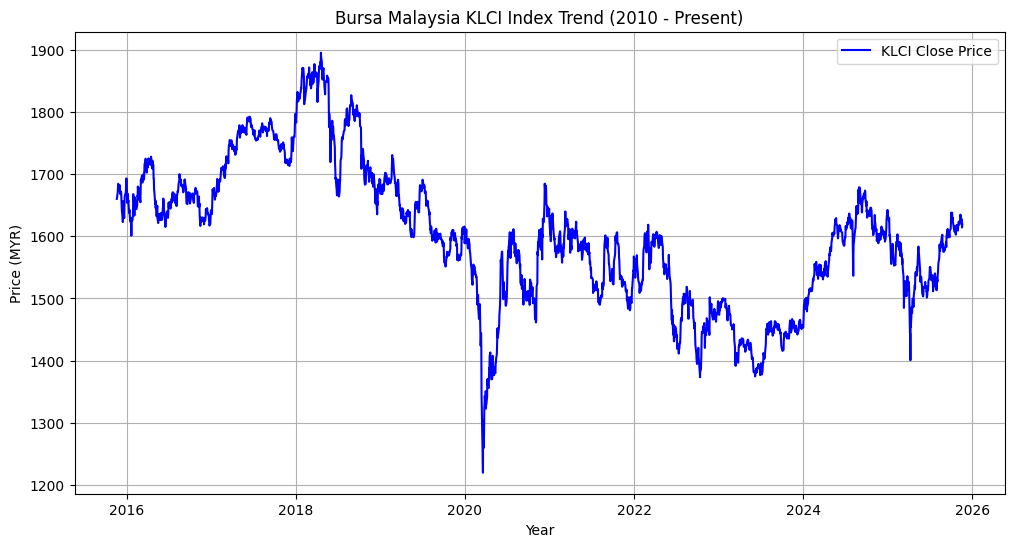

In [ ]:
# Plot the Closing Price
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], label='KLCI Close Price', color='blue')
plt.title('Bursa Malaysia KLCI Index Trend (2010 - Present)')
plt.xlabel('Year')
plt.ylabel('Price (MYR)')
plt.legend()
plt.grid(True)
plt.show()

Training Data Shape: (1701, 20)
Testing Data Shape: (730, 20)

Training Decision Tree Model...

--- Decision Tree Results ---
RMSE: 16.71
MAE:  12.63
MAPE: 0.83%
R2:   0.95


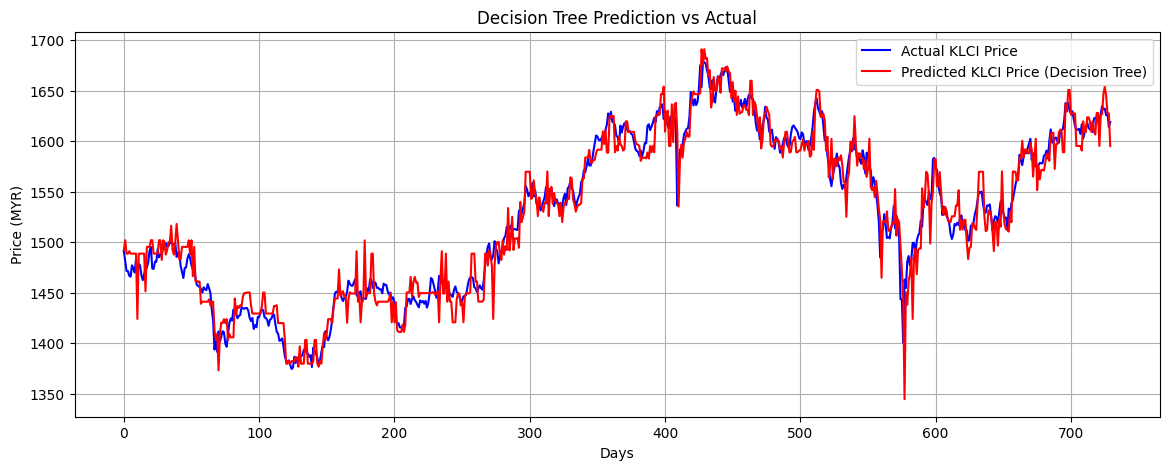

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import math
import numpy as np

# 2. Preprocessing & Sliding Window

# Select Target: We are forecasting the 'Price' (Closing Price)
data = df['Price'].values.reshape(-1, 1)

# Normalize the Data (Scale to range [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define the Sliding Window Function
# Input (X): Day 1 to Day 20
# Output (y): Day 21
def create_dataset(dataset, look_back=20):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

# Apply the Window (Look_back of 20 days)
look_back = 20
X, y = create_dataset(scaled_data, look_back)

# Split into Training and Testing (70% Train / 30% Test)
train_size = int(len(X) * 0.70)
test_size = len(X) - train_size

X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# NOTE: Unlike LSTM, Decision Trees do NOT need 3D reshaping.
# We keep the shape as (Samples, Features) -> (Samples, 20)
print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# 3. Decision Tree Model Training

# Initialize the Decision Tree Regressor
# random_state ensures the results are reproducible
dt_model = DecisionTreeRegressor(random_state=42)

print("\nTraining Decision Tree Model...")
dt_model.fit(X_train, y_train)

# 4. Evaluation & Prediction

# Make Predictions on the Test Set
predictions = dt_model.predict(X_test)

# Reshape for inverse transformation (sklearn expects 2D array)
predictions = predictions.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

# Inverse Transform (Convert normalized '0.55' back to real Price '1600 MYR')
predictions_actual = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test_reshaped)

# Calculate Metrics
rmse = math.sqrt(mean_squared_error(y_test_actual, predictions_actual))
mae = mean_absolute_error(y_test_actual, predictions_actual)
r2 = r2_score(y_test_actual, predictions_actual)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_actual, predictions_actual)

print("\n--- Decision Tree Results ---")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2:   {r2:.2f}")

# 5. Plot the Results

plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, color='blue', label='Actual KLCI Price')
plt.plot(predictions_actual, color='red', label='Predicted KLCI Price (Decision Tree)')
plt.title('Decision Tree Prediction vs Actual')
plt.xlabel('Days')
plt.ylabel('Price (MYR)')
plt.legend()
plt.grid(True)
plt.show()